In [2]:
import pandas as pd

df = pd.read_csv("../../data/processed/train_dataset_scaled.csv")
df.head()

,longitude,latitude,source,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,mag_uc_1_2km,mag_uc_2_4km,mag_uc_4_8km,mag_uc_8_12km,...,radio_u_ppm_log,radio_k_pct_log,radio_u_th_ratio_log,radio_th_k_ratio_log,radio_u_k_ratio_log,mag_uc_1_2km_clipped,mag_uc_2_4km_clipped,mag_uc_4_8km_clipped,mag_uc_8_12km_clipped,mag_uc_12_16km_clipped
0,134.324653,-27.294063,blank_area,-204.018005,-426.38882,-309.04285,-19.665098,-33.036575,-46.971394,-30.871347,...,0.127237,0.333311,-0.124671,0.397798,-0.009543,-0.668663,-0.851250,-0.945436,-0.959623,0.214549
1,148.050504,-32.937903,positive,93.298981,-186.38301,-2674.96260,-44.330212,23.895699,107.432144,82.715973,...,0.415305,0.453097,0.467035,0.327253,-0.293551,-1.586962,0.657309,2.155678,2.561795,0.834904
2,119.027100,-22.975700,other_deposit,-200.687836,-739.63226,-1203.50880,-442.748383,-354.920288,-211.401382,-84.787079,...,-0.975914,0.070219,0.703944,0.435587,0.747842,-7.796670,-4.257698,-2.802553,-2.229055,0.000000
3,121.464232,-23.649192,blank_area,-163.918274,-592.99493,-536.70370,18.632324,31.867907,50.295372,35.592964,...,-1.432342,0.099784,-0.368764,0.437983,0.176291,0.757176,0.868552,1.008116,1.100894,0.580820
4,142.469900,-35.168600,other_deposit,-81.172989,-139.28423,-507.28357,-0.266748,-0.374094,-0.820666,-0.999457,...,-0.259067,0.204139,1.039777,0.388364,0.459511,0.053551,0.014222,-0.018523,-0.033539,0.376088


## 1. Feature Selection: Principles & Methodology

Feature selection is a crucial step before model training, especially in geoscience-based machine learning, where input features may come from diverse sources (e.g., gravity, magnetics, radiometric ratios) and exhibit complex distributions or redundancies.

In this notebook, we apply a multi-step feature selection strategy with the following goals:


### 1.1. Objectives

- Reduce **irrelevant or redundant features** to prevent overfitting and improve model generalization.
- Handle **highly correlated variables** which may distort model interpretations and variable importance rankings.
- Retain features with strong **predictive power** and clear **geoscientific meaning**.
- Ensure model stability and reduced noise, especially in the presence of skewed or spatially autocorrelated data.

### 1.2. Methodology Overview

1. **Low Variance Filtering**  
   - Features with near-constant values (variance < 0.01) provide little information and are removed.

2. **Correlation-Based Redundancy Removal**  
   - Pearson correlation coefficients are computed.
   - One feature from each highly correlated pair (r > 0.9) is dropped to reduce multicollinearity.

3. **(Optional) Model-Based Feature Importance**  
   - A lightweight Random Forest is trained to evaluate feature contributions.
   - This step provides insights into which features are truly informative.


## 2.Gravity Feature Inclusion Strategy

Although gravity features were not transformed via `log` or `clip`, they are retained in the final modeling feature set because:

- They are geophysically interpretable and relatively well-behaved.
- Their original units carry physical meaning crucial for geological inference.
- These features have not exhibited extreme skewness and are safe to include as-is.

Therefore, all features that are either:
- Transformed (`*_log`, `*_clipped`), or
- Raw gravity features (`gravity_*`)
are selected for the final model input.


In [3]:
# keep _log / _clipped features +  original gravity feature
feature_cols = [
    col for col in df.columns 
    if (col.endswith('_log') or col.endswith('_clipped') or col.startswith('gravity_'))
]

X = df[feature_cols]
y = df['label']

In [4]:
from sklearn.feature_selection import VarianceThreshold

# Set threshold to a small value (e.g., near-constant = 0.01)
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X)

# Retain feature names
selected_vt_cols = X.columns[vt.get_support()]
print("Remaining after low variance filter:", len(selected_vt_cols))

Remaining after low variance filter: 14


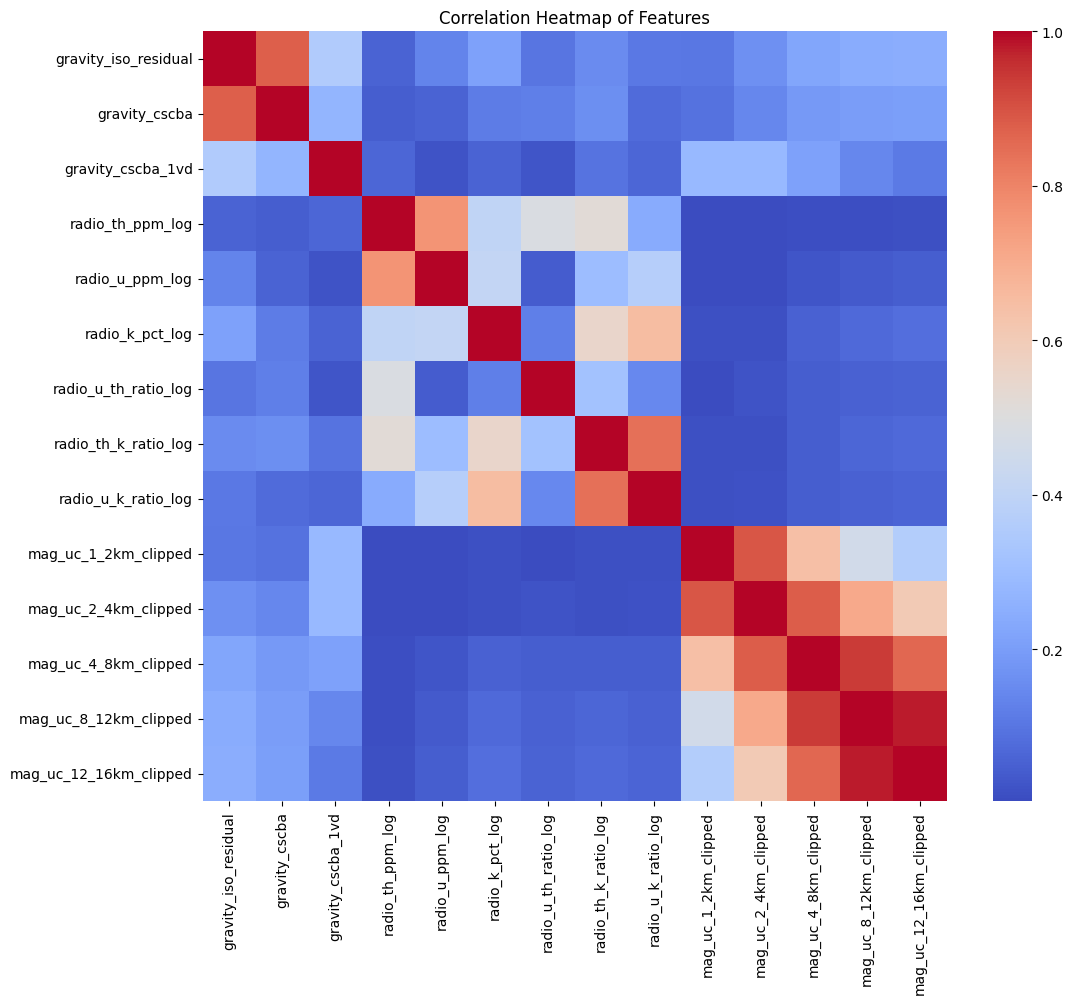

Highly correlated features (r > 0.9): ['mag_uc_8_12km_clipped', 'mag_uc_12_16km_clipped']


In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = X[selected_vt_cols].corr().abs()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

# Identify highly correlated pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.9)]
print("Highly correlated features (r > 0.9):", high_corr)


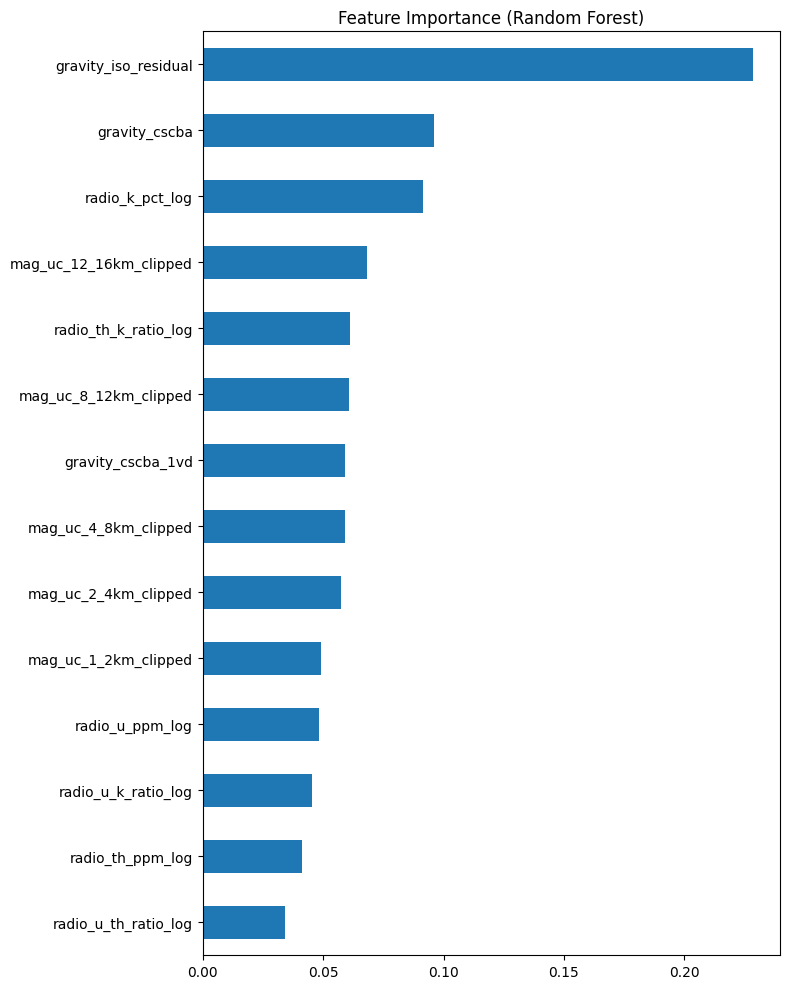

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 10))
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


For each such pair, we retained the feature with **higher importance** (based on Random Forest), and removed the weaker one `mag_uc_8_12km_clipped`.

`mag_uc_12_16km_clipped` > `mag_uc_8_12km_clipped`

In [20]:
# Drop correlated features
print("Keep", high_corr[1])
X_selected = X[selected_vt_cols].drop(columns=high_corr[0])

Keep mag_uc_12_16km_clipped


## 3. Feature Selection Summary

This step systematically reduced feature redundancy and preserved only the most informative geoscientific features for modeling. The selection process was guided by:

### Step 1: Low-Variance Filtering

- All features passed the variance threshold (`threshold = 0.01`)
- No features removed for near-zero variance

---

### Step 2: Correlation-Based Redundancy Removal

- Pearson correlation analysis was performed on all preprocessed features.
- Two magnetic features showed strong multicollinearity (r > 0.9) with other bands:
  - `mag_uc_8_12km_clipped`
- It was **removed** to reduce redundancy.

---

### Step 3: Feature Importance (Random Forest)

A lightweight Random Forest classifier (n=100) was trained on the remaining features to rank their contribution to porphyry copper prediction. Key insights:

- **Top 5 important features**:
  - `gravity_iso_residual`
  - `gravity_cscba`
  - `radio_k_pct_log`
  - `mag_uc_12_16km_clipped` 
  - `radio_th_k_ratio_log`

- Gravity features showed **dominant importance**, reaffirming their geophysical relevance.
- Clipped magnetics and log-transformed radiometrics also contributed meaningfully.
- Some log-transformed geochemical ratios (`radio_u_th_ratio_log`, etc.) had lower importance.

---

### Final Feature Set (13 features selected):

| Category             | Features                                                                 |
|----------------------|--------------------------------------------------------------------------|
|  Gravity            | `gravity_iso_residual`, `gravity_cscba`, `gravity_cscba_1vd`             |
|  Radiometric (log) | `radio_th_ppm_log`, `radio_u_ppm_log`, `radio_k_pct_log`                |
|  Ratios (log)      | `radio_th_k_ratio_log`, `radio_u_k_ratio_log`, `radio_u_th_ratio_log`   |
|  Magnetics (clip)  | `mag_uc_1_2km_clipped`, `mag_uc_2_4km_clipped`, `mag_uc_4_8km_clipped`, `mag_uc_12_16km_clipped`   |

---

### Output

- Final feature matrix with 13 columns and label saved to: `train_dataset_selected.csv`
- Cleaned, scaled, and feature-selected dataset now ready for training and tuning

This curated input will enhance model robustness, reduce noise, and retain key geoscientific patterns.

In [21]:
final_feature_list = X_selected.columns.tolist()

df_final = df[final_feature_list + ['label']]
df_final.to_csv("../../data/processed/train_dataset_selected.csv", index=False)

print(f"Final feature dataset shape: {df_final.shape}")
print("../../data/processed/train_dataset_selected.csv")


Final feature dataset shape: (2850, 14)
../../data/processed/train_dataset_selected.csv
